<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 Web APIs and NLP

_Authors: Joel Quek (SG)_

# Problem Statement

NLP Model to match posts from r/investing, r/stockmarket, r/wallstreetbets

[Reddit Post Classification](https://towardsdatascience.com/reddit-post-classification-b70258d6affe)

[Text Cleaning for NLP: A Tutorial](https://monkeylearn.com/blog/text-cleaning/) [Important]

# Exploratory Data Analysis

## Import Libraries

In [1]:
#All libraries used in this project are listed here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import re
from bs4 import BeautifulSoup 

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, make_scorer, recall_score, precision_score,accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score


# Open Scraped Datasets

The jupytyer notebooks for scraping are 'reddit-scrape.ipynb' and 'wallstreetbets-scrape.ipynb'

In [2]:
investing_df = pd.read_csv('datasets/investing.csv')
stockmarket_df = pd.read_csv('datasets/stockmarket.csv')

## r/investing

In [3]:
investing_df.shape

(7995, 75)

In [4]:
investing_df.iloc[investing_df.shape[0]-1]['created_utc']

# GMT: Friday, July 8, 2022 9:18:46 AM

1657271926

In [5]:
investing_df=investing_df[['subreddit', 'author', 'selftext', 'title']]
investing_df.head()

,subreddit,author,selftext,title
0,investing,HomeInvading,"Hey guys, I’m a 22 year old male, I grew up wi...",Help a young man out would ya?
1,investing,ocean-airseashell10,[removed],Treasury bonds is it a good idea to buy
2,investing,ocean-airseashell10,[removed],How to buy treasury bonds? Is treasury’s direc...
3,investing,iamjokingiamserious,[removed],Early Exercise of Stock Options
4,investing,jamesterryburke01,Hello Redditors 👋 \n\nI work as a Investment C...,Alternative Investments -


## r/stockmarket

In [6]:
stockmarket_df.shape

(7494, 81)

In [7]:
stockmarket_df.iloc[stockmarket_df.shape[0]-1]['created_utc']

# GMT: Wednesday, July 13, 2022 2:13:58 AM

1657678438

In [8]:
stockmarket_df=stockmarket_df[['subreddit', 'author', 'selftext', 'title']]
stockmarket_df.head()

,subreddit,author,selftext,title
0,StockMarket,zitrored,NaN,Looking for the next exogenous event that take...
1,StockMarket,CompetitiveMission1,[Link to the full article (4 min read)](https:...,China stocks notch trillion-dollar gain on hop...
2,StockMarket,jaltrading21,NaN,Get ready for some economic news and company e...
3,StockMarket,ShabbyShamble,NaN,Market Recap! Bear Market Blues! Palantir (PLT...
4,StockMarket,PriceActionHelp,NaN,Why it's not smart to rely on the RSI divergence


# Final Cleaning 

## Handling Missing Values

In [9]:
investing_df['selftext']=investing_df['selftext'].fillna('')
stockmarket_df['selftext']=stockmarket_df['selftext'].fillna('')


In [10]:
investing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7995 entries, 0 to 7994
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  7995 non-null   object
 1   author     7995 non-null   object
 2   selftext   7995 non-null   object
 3   title      7995 non-null   object
dtypes: object(4)
memory usage: 250.0+ KB


In [11]:
stockmarket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7494 entries, 0 to 7493
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  7494 non-null   object
 1   author     7494 non-null   object
 2   selftext   7494 non-null   object
 3   title      7494 non-null   object
dtypes: object(4)
memory usage: 234.3+ KB


## Feature Engineering

I will combine the text from columns 'author','selftext' and 'title'

In [12]:
#investing_df['Posts']='Author: '+investing_df['author']+' Title: ' + investing_df['title']+' Text: '+investing_df['selftext']
#stockmarket_df['Posts']='Author: '+stockmarket_df['author']+' Title: ' + stockmarket_df['title']+' Text: '+stockmarket_df['selftext']


In [13]:
investing_df['Posts']=investing_df['author']+ ' '+investing_df['title']+' '+investing_df['selftext']
stockmarket_df['Posts']=stockmarket_df['author']+ ' '+stockmarket_df['title']+' '+stockmarket_df['selftext']

In [14]:
investing_df=investing_df[['subreddit','Posts']]
stockmarket_df=stockmarket_df[['subreddit','Posts']]


In [15]:
investing_df.head(3)

,subreddit,Posts
0,investing,HomeInvading Help a young man out would ya? He...
1,investing,ocean-airseashell10 Treasury bonds is it a goo...
2,investing,ocean-airseashell10 How to buy treasury bonds?...


In [16]:
stockmarket_df.head(3)

,subreddit,Posts
0,StockMarket,zitrored Looking for the next exogenous event ...
1,StockMarket,CompetitiveMission1 China stocks notch trillio...
2,StockMarket,jaltrading21 Get ready for some economic news ...


## Concatenate both Dataframes

In [17]:
df = pd.concat([investing_df,stockmarket_df],ignore_index=True)

In [18]:
df.shape

(15489, 2)

In [19]:
df['subreddit'].value_counts()

investing      7995
StockMarket    7494
Name: subreddit, dtype: int64

In [20]:
df.head()

,subreddit,Posts
0,investing,HomeInvading Help a young man out would ya? He...
1,investing,ocean-airseashell10 Treasury bonds is it a goo...
2,investing,ocean-airseashell10 How to buy treasury bonds?...
3,investing,iamjokingiamserious Early Exercise of Stock Op...
4,investing,jamesterryburke01 Alternative Investments - He...


## Lowercase

In [21]:
df['Posts']=[c.lower() for c in df['Posts']]

## Remove Non Letters

In [22]:
df['Posts']=df['Posts'].map(lambda x: re.sub("[^a-zA-Z]", " ", x)) 

## Remove Stop Words

In [23]:
def remove_stop_words(text):
    stops = stopwords.words('english')
    stops=set(stops)
    text = " ".join([word for word in text.split() if word not in (stops)])
    # text = [w for w in text if not w in stops]

    return text

In [24]:
df['Posts']=df['Posts'].map(lambda x: remove_stop_words(x))

## Hot Encode Target Vector

In [25]:
df['subreddit']=df['subreddit'].map({'investing': 0, 'StockMarket': 1})

In [26]:
df.head()

,subreddit,Posts
0,0,homeinvading help young man would ya hey guys ...
1,0,ocean airseashell treasury bonds good idea buy...
2,0,ocean airseashell buy treasury bonds treasury ...
3,0,iamjokingiamserious early exercise stock optio...
4,0,jamesterryburke alternative investments hello ...


In [27]:
X=df['Posts']
y=df['subreddit']

In [28]:
y.value_counts(normalize = True)

0    0.516173
1    0.483827
Name: subreddit, dtype: float64

In [29]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

----

# Count Vectorizer

In [30]:
# Instantiate a CountVectorizer with the default hyperparameters.
cvec = CountVectorizer()

In [31]:
# Fit the vectorizer on our corpus.
cvec.fit(X_train)

CountVectorizer()

In [32]:
# Transform the corpus.
X_train = cvec.transform(X_train) 
# transform creates the vector of words

In [33]:
X_train.shape

(10377, 29062)

In [34]:
print(X_train)

  (0, 492)	1
  (0, 1333)	1
  (0, 5180)	1
  (0, 10765)	1
  (0, 13654)	1
  (0, 14529)	1
  (0, 16149)	1
  (0, 16984)	1
  (0, 25442)	1
  (0, 25662)	1
  (1, 286)	1
  (1, 3116)	1
  (1, 3428)	1
  (1, 12578)	1
  (1, 20803)	1
  (1, 21060)	1
  (2, 358)	1
  (2, 3506)	1
  (2, 3521)	1
  (2, 4505)	1
  (2, 4593)	1
  (2, 6099)	2
  (2, 7480)	1
  (2, 8155)	1
  (2, 8625)	1
  :	:
  (10376, 11061)	1
  (10376, 11282)	1
  (10376, 11283)	1
  (10376, 11787)	1
  (10376, 11897)	2
  (10376, 12933)	1
  (10376, 12953)	3
  (10376, 12968)	1
  (10376, 14538)	1
  (10376, 15784)	1
  (10376, 15999)	1
  (10376, 16307)	1
  (10376, 16868)	1
  (10376, 18821)	1
  (10376, 19351)	1
  (10376, 19365)	1
  (10376, 19585)	1
  (10376, 22157)	1
  (10376, 22451)	1
  (10376, 23042)	1
  (10376, 24014)	1
  (10376, 25441)	1
  (10376, 25507)	1
  (10376, 26096)	1
  (10376, 27092)	1


In [35]:
cvec.get_feature_names()[1000:1010]

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['amikuna',
 'amilton',
 'amit',
 'aml',
 'amlp',
 'amlzf',
 'ammakshooter',
 'ammo',
 'ammonia',
 'ammonium']

In [36]:
# Transform test
X_test = cvec.transform(X_test) # we fit the CountVectorizer data based on the X_Train and use that model to transform T_Test

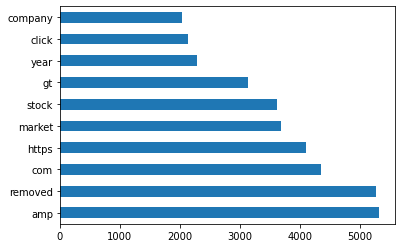

In [37]:
# convert training data to dataframe
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names()) # cvec is the CountVectorizer object

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh'); # head(10) gives top ten words

## Baseline Accuracy

In [38]:
y_test.value_counts(normalize=True)

0    0.516236
1    0.483764
Name: subreddit, dtype: float64

# Reinstantiate Train and Test Data [Should I do this for random forest?]

To avoid error of instantiating/fitting count vectorizer down below [IMPORTANT]

In [39]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

# 1. Random Forest with Count Vectorizer

In [40]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Random Forest (estimator)

pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [41]:
cross_val_score(pipe1, X_train, y_train, cv=5)

array([0.81021195, 0.81213873, 0.79614458, 0.80626506, 0.80722892])

In [42]:
# ii. Fit into model
pipe1.fit(X_train, y_train)

# Training score
print(pipe1.score(X_train, y_train))

0.994410716006553


In [43]:
# Test score
print(pipe1.score(X_test, y_test))

0.8077073552425665


## Random Forest Versus Extra Trees [Comparison]

In [44]:
rf = RandomForestClassifier(n_estimators=100)

In [45]:
et = ExtraTreesClassifier(n_estimators=100)

## Model Evaluation [Random Forest Versus Extra Trees]
---

Which one has a higher `cross_val_score`?

In [46]:
cross_val_score(rf, X_train_df, y_train, cv=5).mean()

0.8102528959769716

In [47]:
cross_val_score(et, X_train_df, y_train, cv=5).mean()

0.8092890405552847

## Gridsearch with Count Vectorizer

### Applying Count Vectorizer on Training Data 

In [54]:
X_train = cvec.transform(X_train) 

AttributeError: lower not found

In [ ]:
# convert training data to dataframe
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names()) # cvec is the CountVectorizer object

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [53]:
rf_params = {
    #'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    #'cvec__min_df': [2, 3],
    #'cvec__max_df': [.9, .95],
    #'cvec__ngram_range': [(1,1), (1,2)],
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5], # max_depth is the longest path
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train_df, y_train)
print(gs.best_score_)
gs.best_params_

0.8103487708057664


{'max_depth': None, 'n_estimators': 150}

In [55]:
gs.score(X_train_df, y_train)

0.994410716006553

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

In [60]:
# Transform test
X_test = cvec.transform(X_test) # we fit the CountVectorizer data based on the X_Train and use that model to transform T_Test

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


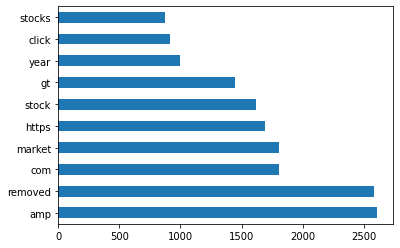

In [61]:
# convert testing data to dataframe
X_test_df = pd.DataFrame(X_test.todense(), 
                          columns=cvec.get_feature_names()) # cvec is the CountVectorizer object

# plot top occuring words
X_test_df.sum().sort_values(ascending=False).head(10).plot(kind='barh'); # head(10) gives top ten words

In [63]:
gs.score(X_test, y_test) # or X_test_df ? 

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.8096635367762128

## Error Analysis [Type 1 and Type 2 Errors]

https://www.datasciencecentral.com/understanding-type-i-and-type-ii-errors/


In [64]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score


#### Gridsearch Accuracy

In [65]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [66]:
cm2 = confusion_matrix(y_test, preds)
cm2

array([[2254,  385],
       [ 588, 1885]], dtype=int64)

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


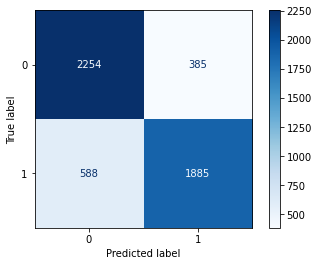

In [67]:
# View confusion matrix

plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [68]:
# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8541114058355438


In [69]:
# Calculate the sensitivity

sens = tp/(tp+fn)

print('Sensitivity:', sens)

Sensitivity: 0.7622321067529316


In [70]:
accuracy = (tp+tn)/(tp+fp+tn+fn)

print('Accuracy:', accuracy)

Accuracy: 0.8096635367762128


## Error Analysis [Type 1 and Type 2 Errors]

https://www.datasciencecentral.com/understanding-type-i-and-type-ii-errors/


### How many Type I errors [FALSE POSITIVE] are there?


In [71]:
fp

385

### How many Type II errors [FALSE NEGATIVE] are there?


In [72]:
fn

588

### Which error is worse (Type I vs Type II)?


## ROC Curve

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


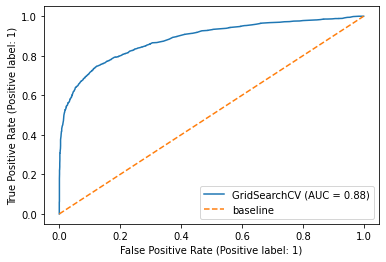

In [73]:
plot_roc_curve(gs, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

The area under the ROC curve measures the degree of overlap between the Specificity and Sensitivity distributions. Greater the area, the less overlap.

---

# 1. Random Forest with TFID Vectorizer

In [74]:
# Let's set a pipeline up with two stages:
# 1. TFIDVectorizer (transformer)
# 2. Random Forest (estimator)

pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

## Reinstantiate Train and Test Data [Should I do this for random forest?]

To avoid error of instantiating/fitting count vectorizer down below [IMPORTANT]

In [75]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

In [76]:
cross_val_score(pipe2, X_train, y_train, cv=5)

array([0.81936416, 0.80491329, 0.79373494, 0.80289157, 0.8       ])

In [77]:
# ii. Fit into model
pipe2.fit(X_train, y_train)

# Training score
print(pipe2.score(X_train, y_train))

0.994410716006553


In [78]:
print(pipe2.score(X_test, y_test))

0.8102503912363067


## Gridsearch with TFID Vectorizer

In [79]:
# Instantiate a CountVectorizer with the default hyperparameters.
tvec = TfidfVectorizer()

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

In [91]:
X_train = tvec.transform(X_train) 

In [92]:
# convert training data to dataframe
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names()) # cvec is the CountVectorizer object

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [93]:
rf_params = {
    #'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    #'tvec__stop_words': [None, 'english'],
    #'tvec__ngram_range': [(1,1), (1,2)] # what about min_df and max_df?
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5], # max_depth is the longest path
}
gs2 = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs2.fit(X_train_df, y_train)
print(gs2.best_score_)
gs2.best_params_

In [ ]:
gs2.score(X_train_df, y_train)

In [ ]:
# convert testing data to dataframe
X_test_df = pd.DataFrame(X_test.todense(), 
                          columns=cvec.get_feature_names()) # cvec is the CountVectorizer object

# plot top occuring words
X_test_df.sum().sort_values(ascending=False).head(10).plot(kind='barh'); # head(10) gives top ten words

In [ ]:
gs2.score(X_test, y_test) # or X_test_df ? 